# Setting

In [1]:
from pf_utils import PortfolioManager as PM 
from pf_utils import BayesianEstimator, performance_stats, get_date_range, METRICS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

In [3]:
file_cost='transaction_cost'
kw_cost = {'cost': file_cost}

# Data

In [18]:
universe = 'UV_FUND'
fund = PM.create_universe(universe)
cost = PM.get_cost(universe, file=file_cost, path=path_tran)
fee = cost['fee']

64 securities from 2008-11-28 to 2024-11-29 uploaded.
REMINDER: 64 equities converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless
Price data loaded
Cost data transaction_cost_241217.csv loaded


In [28]:
df_prices = fund.df_prices
df_prices_fees = fund._get_prices_after_fee(df_prices, fee)

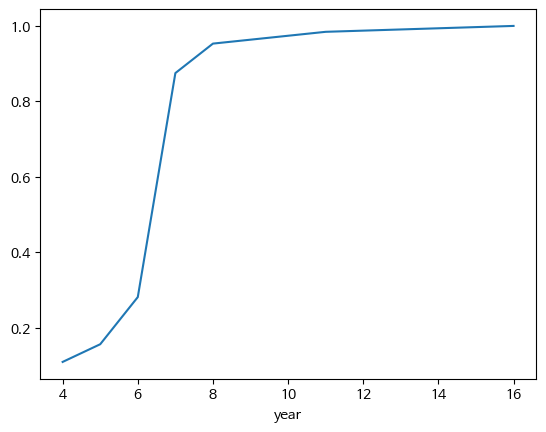

In [29]:
days_in_year = fund.days_in_year
df_year = get_date_range(df_prices).loc[:, 'n'].div(days_in_year).rename('year')
_ = df_year.groupby(df_year.round()).count().cumsum().div(df_year.count()).plot()

In [30]:
y = 5
tickers = df_year.loc[df_year >= y].index.to_list()
len(tickers)

57

In [31]:
df_prices = df_prices[tickers]
df_prices_fees = df_prices_fees[tickers]

# Bayesian

## 1 Year Rate of Return

### Estimate

In [10]:
kw = dict(
    days_in_year = 365,
    security_names = fund.security_names
)
be = BayesianEstimator(df_prices_fees, **kw)

In [11]:
metric = 'cagr'
be.get_stats(metric).T.sort_values(metric, ascending=False)

,start,end,cagr
K55364CF7048,2019-04-30,2024-11-29,0.100327
K55234DF3317,2021-04-30,2024-11-29,0.086218
K55303BT4176,2017-11-30,2024-11-29,0.084917
K55301BM7459,2017-03-31,2024-11-29,0.080224
K55234DF3150,2021-04-30,2024-11-29,0.080166
...,...,...,...
KR5236AS4826,2014-05-30,2024-11-29,0.028424
KR5370AP9956,2014-04-30,2024-11-29,0.020358
K55306CV9946,2019-10-31,2024-11-29,0.016814
K55370BU1979,2017-08-31,2024-11-29,0.015582


In [10]:
file = 'fund_ror_1y'
be.bayesian_sample(freq='1y', file=file, path=path_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1193 seconds.


### Load

In [9]:
file = 'fund_ror_1y'
kw = dict(
    days_in_year = 365,
    security_names = fund.security_names
)
be = BayesianEstimator.create(file, path_data, **kw)

data/fund_ror_1y.pkl loaded


### Compare

In [10]:
var_names = ['ror', 'sharpe']
df_s = be.bayesian_summary(var_names)
df_s

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
metric ticker                                                            
ror    K55234DF2657  0.018  0.080  -0.127    0.172      0.001    0.002   
       K55234DF2459  0.034  0.089  -0.137    0.198      0.001    0.002   
       K55301BU6139  0.069  0.115  -0.133    0.301      0.001    0.002   
       K55105BU1161  0.038  0.097  -0.137    0.233      0.001    0.002   
       K55210BU2385  0.044  0.087  -0.126    0.203      0.001    0.001   
...                    ...    ...     ...      ...        ...      ...   
sharpe K55105BT9936  0.387  0.022   0.344    0.426      0.000    0.000   
       K55223BT1096  0.463  0.022   0.424    0.504      0.000    0.000   
       K55301BU6113  0.599  0.023   0.555    0.641      0.000    0.000   
       K55101BT4402  0.398  0.022   0.357    0.438      0.000    0.000   
       K55370BU1979  0.182  0.022   0.140    0.222      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
metric ticker                                   
ror    K55234DF2657   10125.0    2675.0   1.00  
       K55234DF2459   12327.0    2663.0   1.01  
       K55301BU6139   11779.0    2529.0   1.00  
       K55105BU1161   11206.0    2435.0   1.00  
       K55210BU2385    9663.0    2623.0   1.00  
...                       ...       ...    ...  
sharpe K55105BT9936   11572.0    2606.0   1.00  
       K55223BT1096   11131.0    2929.0   1.00  
       K55301BU6113   11100.0    2733.0   1.00  
       K55101BT4402   10871.0    2654.0   1.00  
       K55370BU1979   12085.0    2606.0   1.01  

[128 rows x 9 columns]

In [11]:
m = 'ror'

#c = 'hdi_3%'
c = 'mean'

df = df_s.loc[m]
tickers = df.loc[df[c]>0].index
len(tickers)

64

In [12]:
n = 10
tickers = df[c].sort_values(ascending=False).iloc[:n].index.to_list()

In [13]:
import pandas as pd
idx = pd.IndexSlice
df_s.loc[idx[m, tickers], :].sort_values('mean', ascending=False)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
metric ticker                                                            
ror    K55303BT4176  0.120  0.256  -0.338    0.611      0.002    0.004   
       K55364CF7048  0.106  0.155  -0.178    0.401      0.002    0.002   
       K55203C53681  0.101  0.247  -0.380    0.535      0.002    0.004   
       K55234BY9966  0.098  0.240  -0.343    0.544      0.002    0.004   
       K55365BT3694  0.083  0.246  -0.380    0.536      0.002    0.004   
       K55213C50702  0.080  0.121  -0.138    0.313      0.001    0.002   
       K55301BU5479  0.077  0.129  -0.184    0.304      0.001    0.002   
       K55210CO3828  0.075  0.122  -0.163    0.298      0.001    0.002   
       K55213C51890  0.075  0.121  -0.149    0.301      0.001    0.002   
       K55301BM7459  0.074  0.120  -0.159    0.295      0.001    0.002   

                     ess_bulk  ess_tail  r_hat  
metric ticker                                   
ror    K55303BT4176   12191.0    2362.0    1.0  
       K55364CF7048   10493.0    2944.0    1.0  
       K55203C53681   11077.0    2576.0    1.0  
       K55234BY9966   11995.0    2943.0    1.0  
       K55365BT3694   10918.0    2664.0    1.0  
       K55213C50702   10461.0    2704.0    1.0  
       K55301BU5479   11747.0    3054.0    1.0  
       K55210CO3828    9864.0    2891.0    1.0  
       K55213C51890   11220.0    2716.0    1.0  
       K55301BM7459   11016.0    2826.0    1.0

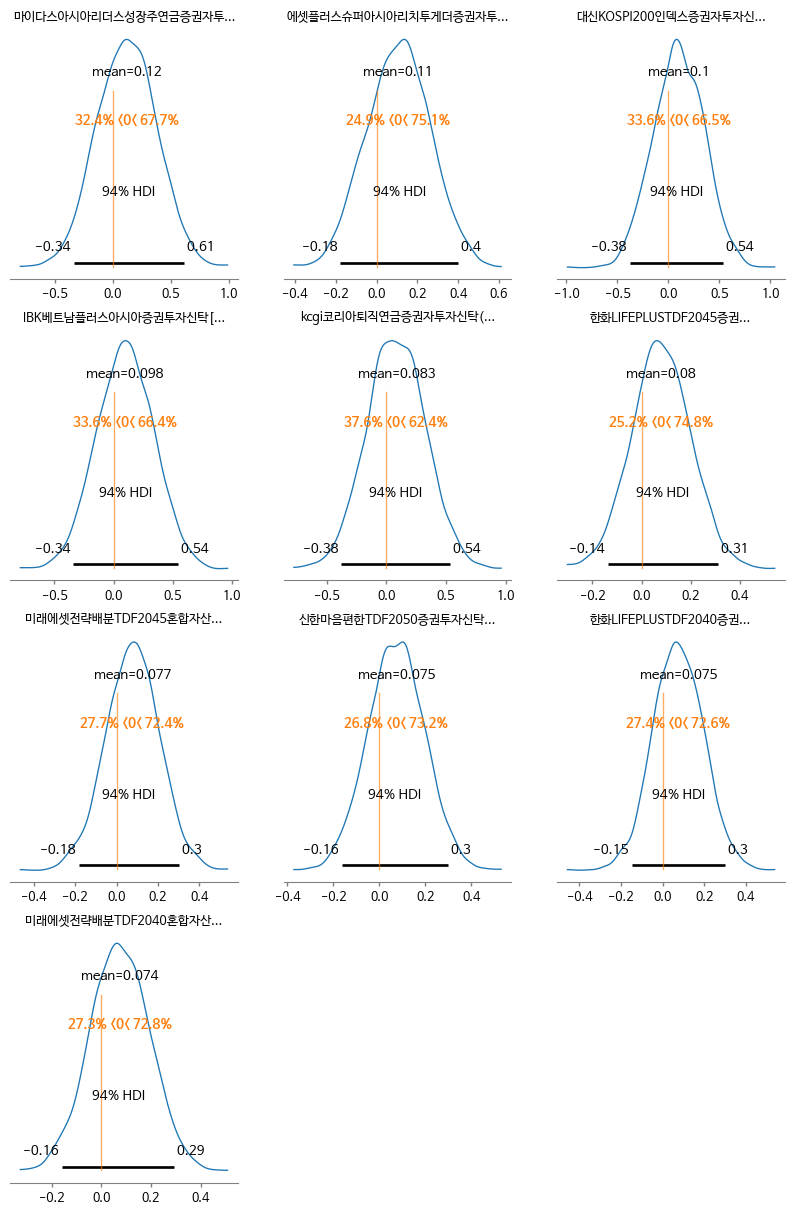

In [14]:
be.plot_posterior(var_names[0], tickers, figsize=(10,15), textsize=9)

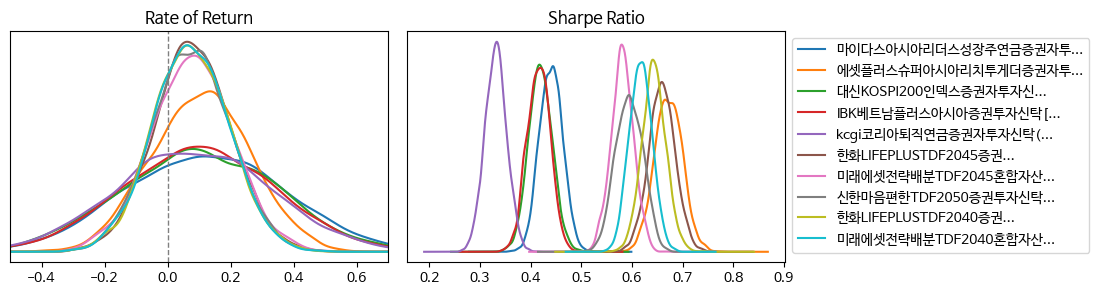

In [15]:
_ = be.plot_returns(tickers, xlim=(-0.5, 0.7))

## 3 Year Rate of Return

### Estimate

In [32]:
kw = dict(
    days_in_year = 365,
    security_names = fund.security_names
)
be = BayesianEstimator(df_prices_fees, **kw)

In [33]:
metric = 'cagr'
be.get_stats(metric).T.sort_values(metric, ascending=False)

,start,end,cagr
K55364CF7048,2019-04-30,2024-11-29,0.100327
K55303BT4176,2017-11-30,2024-11-29,0.084917
K55301BM7459,2017-03-31,2024-11-29,0.080224
K55301BU5479,2017-08-31,2024-11-29,0.075421
K55301BM7640,2017-03-31,2024-11-29,0.075333
K55301BU6253,2017-08-31,2024-11-29,0.074679
K55213C50702,2018-05-31,2024-11-29,0.074238
K55210CO3828,2019-04-30,2024-11-29,0.071492
K55213C51890,2018-05-31,2024-11-29,0.069571
K55301BU6139,2017-09-29,2024-11-29,0.068984


In [34]:
file = 'fund_ror_3y'
be.bayesian_sample(freq='3y', file=file, path=path_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 682 seconds.


data/fund_ror_3y.pkl saved


### Load

In [9]:
file = 'fund_ror_3y'
kw = dict(
    days_in_year = 365,
    security_names = fund.security_names
)
be = BayesianEstimator.create(file, path_data, **kw)

data/fund_ror_1y.pkl loaded


### Compare

In [35]:
var_names = ['ror', 'sharpe']
df_s = be.bayesian_summary(var_names)
df_s

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
metric ticker                                                            
ror    KR5101888398  0.077  0.026   0.027    0.122      0.000    0.000   
       KR5370AP9956  0.044  0.083  -0.111    0.198      0.001    0.001   
       KR5236AS4826  0.080  0.073  -0.058    0.214      0.001    0.001   
       K55105BH1010  0.095  0.135  -0.156    0.345      0.001    0.002   
       K55301BM7640  0.211  0.116  -0.019    0.417      0.001    0.001   
...                    ...    ...     ...      ...        ...      ...   
sharpe K55210CO3828  2.324  0.064   2.197    2.436      0.001    0.000   
       K55364CF7048  2.858  0.073   2.720    2.994      0.001    0.001   
       K55101BY3944  0.146  0.036   0.082    0.217      0.000    0.000   
       K55306CV9946 -1.374  0.051  -1.470   -1.276      0.001    0.000   
       K55101CU1644  1.036  0.045   0.951    1.121      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
metric ticker                                   
ror    KR5101888398   10900.0    2595.0    1.0  
       KR5370AP9956   10546.0    2803.0    1.0  
       KR5236AS4826    9738.0    2538.0    1.0  
       K55105BH1010   10199.0    2604.0    1.0  
       K55301BM7640    9314.0    2632.0    1.0  
...                       ...       ...    ...  
sharpe K55210CO3828   10738.0    2722.0    1.0  
       K55364CF7048    9643.0    2741.0    1.0  
       K55101BY3944   10934.0    2538.0    1.0  
       K55306CV9946    9509.0    2417.0    1.0  
       K55101CU1644   11841.0    2283.0    1.0  

[114 rows x 9 columns]

In [37]:
m = 'ror'
c = 'hdi_3%'

df = df_s.loc[m]
tickers = df.loc[df[c]>0].index
len(tickers)

4

In [40]:
n = 10
tickers = df[c].sort_values(ascending=False).iloc[:n].index.to_list()

In [44]:
import pandas as pd
idx = pd.IndexSlice
df_s.loc[idx[m, tickers], :].sort_values('mean', ascending=False)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
metric ticker                                                            
ror    K55234BY9966  0.395  0.196   0.029    0.755      0.002    0.002   
       K55301BU5479  0.237  0.141  -0.013    0.524      0.001    0.001   
       K55301BU6253  0.235  0.133  -0.000    0.505      0.001    0.001   
       K55364CF7048  0.217  0.073   0.083    0.358      0.001    0.001   
       K55213C50702  0.208  0.112  -0.007    0.411      0.001    0.001   
       K55223BT1757  0.183  0.107  -0.015    0.380      0.001    0.001   
       K55301BM7731  0.172  0.099  -0.002    0.369      0.001    0.001   
       K55210BU2419  0.172  0.104  -0.010    0.380      0.001    0.001   
       K55210CO3828  0.124  0.055   0.023    0.226      0.001    0.000   
       KR5101888398  0.077  0.026   0.027    0.122      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
metric ticker                                   
ror    K55234BY9966   10757.0    2527.0    1.0  
       K55301BU5479    9128.0    2462.0    1.0  
       K55301BU6253   10646.0    2113.0    1.0  
       K55364CF7048    8966.0    2933.0    1.0  
       K55213C50702   10795.0    2966.0    1.0  
       K55223BT1757   11607.0    2659.0    1.0  
       K55301BM7731   10256.0    2723.0    1.0  
       K55210BU2419   10121.0    2599.0    1.0  
       K55210CO3828    9782.0    2698.0    1.0  
       KR5101888398   10900.0    2595.0    1.0

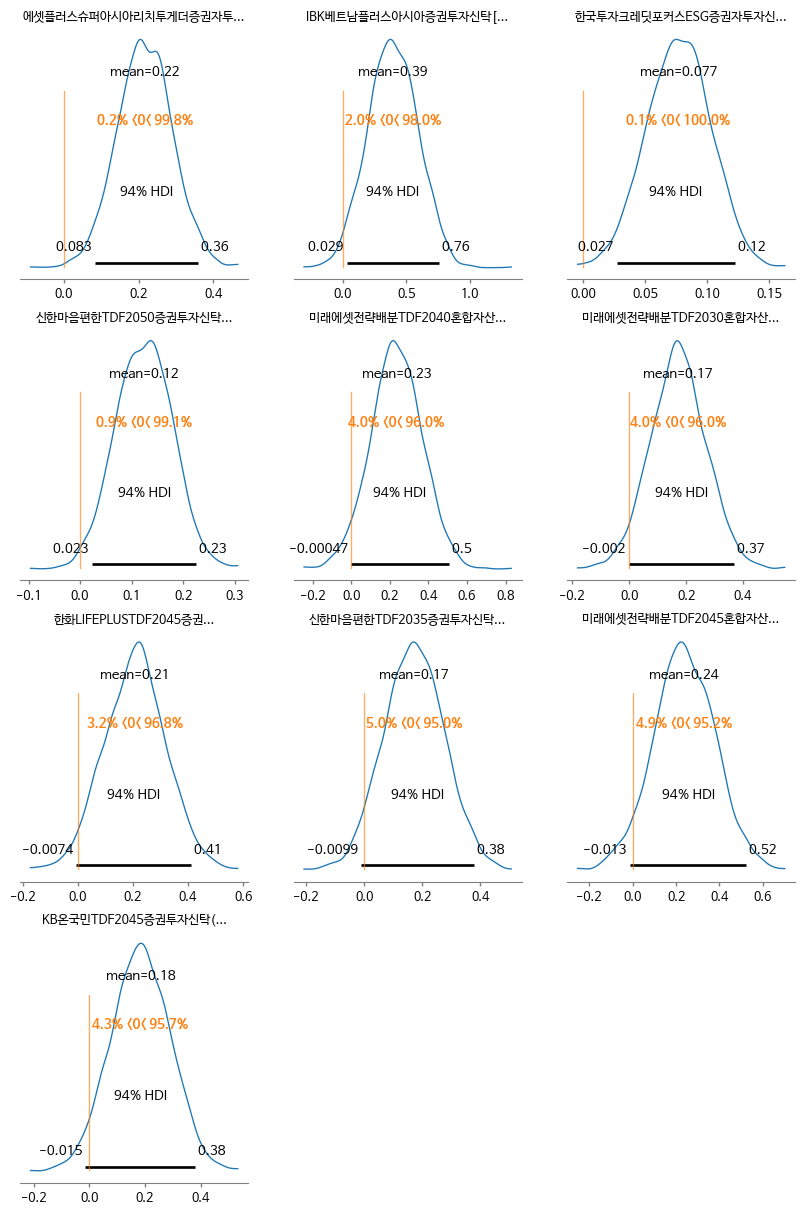

In [43]:
be.plot_posterior(var_names[0], tickers, figsize=(10,15), textsize=9)

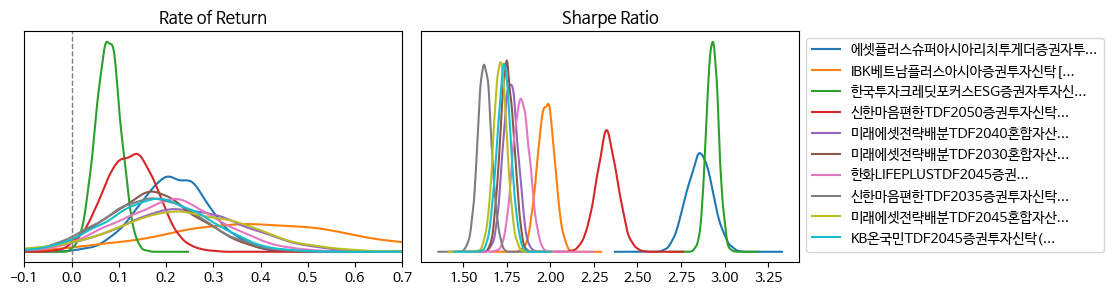

In [46]:
_ = be.plot_returns(tickers, xlim=(-0.1, 0.7))

In [49]:
tickers

['K55364CF7048',
 'K55234BY9966',
 'KR5101888398',
 'K55210CO3828',
 'K55301BU6253',
 'K55301BM7731',
 'K55213C50702',
 'K55210BU2419',
 'K55301BU5479',
 'K55223BT1757']

In [57]:
security_names = {k:v for k,v in fund.security_names.items() if k in tickers}
fund._check_security_names(security_names)

#fund._check_security_names(fund.security_names)

{'K55301BU5479': '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e',
 'K55301BU6253': '미래에셋전략배분TDF2040혼합자산자투자신탁 종류C-P2e',
 'K55364CF7048': '에셋플러스슈퍼아시아리치투게더증권자투자신탁 1(주식)종류C-P2e',
 'K55234BY9966': 'IBK베트남플러스아시아증권투자신탁[주식]종류C-Re',
 'KR5101888398': '한국투자크레딧포커스ESG증권자투자신탁 1(채권)(C-e)',
 'K55301BM7731': '미래에셋전략배분TDF2030혼합자산자투자신탁 종류C-Pe',
 'K55213C50702': '한화LIFEPLUSTDF2045증권투자신탁(혼합-재간접형)C-RPE(퇴직연금)',
 'K55210CO3828': '신한마음편한TDF2050증권투자신탁[주식혼합-재간접형](종류C-re)',
 'K55223BT1757': 'KB온국민TDF2045증권투자신탁(주식혼합-재간접형)C-퇴직e',
 'K55210BU2419': '신한마음편한TDF2035증권투자신탁[주식혼합-재간접형](종류C-re)',
 'K55234DF2657': 'K55234DF2657',
 'K55234DF2459': 'K55234DF2459',
 'K55301BU6139': 'K55301BU6139',
 'K55105BU1161': 'K55105BU1161',
 'K55210BU2385': 'K55210BU2385',
 'K55206C95800': 'K55206C95800',
 'K55210BU2435': 'K55210BU2435',
 'K55213C51890': 'K55213C51890',
 'K55223BT1450': 'K55223BT1450',
 'K55105BS5067': 'K55105BS5067',
 'K55101BY3944': 'K55101BY3944',
 'K55301BU5453': 'K55301BU5453',
 'K55210BU2450': 'K55210BU2450',
 'K55206C96311': 'K

In [55]:
#fund._check_tickers(fund.security_names, tickers, msg=True)
#{k:v for k,v in fund.security_names.items() if k in tickers}

def get_names(self, tickers=None, reset=False, **kwargs):
    """
    tickers: None, 'selected' or list of tickers
    reset: True to get security_names aftre resetting first
    kwargs: additional args for _get_tickers
    """
    security_names = self.security_names
    if reset or (security_names is None):
        security_names = self._get_tickers(tickers, **kwargs)
        if security_names is None:
            return None
        else: # reset security_names
            self.security_names = self._check_security_names(security_names)
    else:
        security_names = self._check_tickers(security_names, tickers, msg=True)
    #return SecurityDict(security_names, names=security_names)
    return security_names
    
from pf_utils import SecurityDict
get_names(fund, tickers)

{'K55301BU5479': '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e',
 'K55301BU6253': '미래에셋전략배분TDF2040혼합자산자투자신탁 종류C-P2e',
 'K55364CF7048': '에셋플러스슈퍼아시아리치투게더증권자투자신탁 1(주식)종류C-P2e',
 'K55234BY9966': 'IBK베트남플러스아시아증권투자신탁[주식]종류C-Re',
 'KR5101888398': '한국투자크레딧포커스ESG증권자투자신탁 1(채권)(C-e)',
 'K55301BM7731': '미래에셋전략배분TDF2030혼합자산자투자신탁 종류C-Pe',
 'K55213C50702': '한화LIFEPLUSTDF2045증권투자신탁(혼합-재간접형)C-RPE(퇴직연금)',
 'K55210CO3828': '신한마음편한TDF2050증권투자신탁[주식혼합-재간접형](종류C-re)',
 'K55223BT1757': 'KB온국민TDF2045증권투자신탁(주식혼합-재간접형)C-퇴직e',
 'K55210BU2419': '신한마음편한TDF2035증권투자신탁[주식혼합-재간접형](종류C-re)',
 'K55234DF2657': 'K55234DF2657',
 'K55234DF2459': 'K55234DF2459',
 'K55301BU6139': 'K55301BU6139',
 'K55105BU1161': 'K55105BU1161',
 'K55210BU2385': 'K55210BU2385',
 'K55206C95800': 'K55206C95800',
 'K55210BU2435': 'K55210BU2435',
 'K55213C51890': 'K55213C51890',
 'K55223BT1450': 'K55223BT1450',
 'K55105BS5067': 'K55105BS5067',
 'K55101BY3944': 'K55101BY3944',
 'K55301BU5453': 'K55301BU5453',
 'K55210BU2450': 'K55210BU2450',
 'K55206C96311': 'K

In [50]:
fund.get_names()

0) K55234DF2657: IBK로우코스트TDF2030증권자투자신탁[혼합-재간접형]종류C-Re
1) K55234DF2459: IBK로우코스트TDF2035증권자투자신탁[혼합-재간접형]종류C-Re
2) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
3) K55105BU1161: 삼성한국형TDF2030증권투자신탁H[주식혼합-재간접형]Cpe(퇴직연금)
4) K55210BU2385: 신한마음편한TDF2030증권투자신탁[주식혼합-재간접형](종류C-re)
5) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
6) K55210BU2435: 신한마음편한TDF2040증권투자신탁[주식혼합-재간접형](종류C-re)
7) K55213C51890: 한화LIFEPLUSTDF2040증권자투자신탁(혼합-재간접형)C-RPe(퇴직연금)
8) K55223BT1450: KB온국민TDF2040증권투자신탁(주식혼합-재간접형)C-퇴직e
9) K55105BS5067: 삼성한국형TDF2040증권투자신탁H[주식혼합-재간접형]C-Pe
10) K55101BY3944: 한국투자TIF알아서평생소득증권자투자신탁(채권혼합-재간접형)(C-Re)
11) K55301BU5453: 미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e
12) K55301BU5479: 미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e
13) K55210BU2450: 신한마음편한TDF2045증권투자신탁[주식혼합-재간접형](종류C-re)
14) K55206C96311: 키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
15) KR5223AE3357: kb퇴직연금배당증권자투자신탁(주식)C-E
16) K55365BT3694: kcgi코리아퇴직연금증권자투자신탁(주식)종류C-Pe2
17) K55207BU0715: 교보악사파워인덱스증권자투자신탁1호(주식)C-Pe
18) K55203C53681: 대신KOSPI200인덱스증권자투자신탁(주식-

# testing

In [5]:
tickers = {k:v for k,v in fund.security_names.items() if 'TDF2045' in v}
tickers = list(tickers.keys())

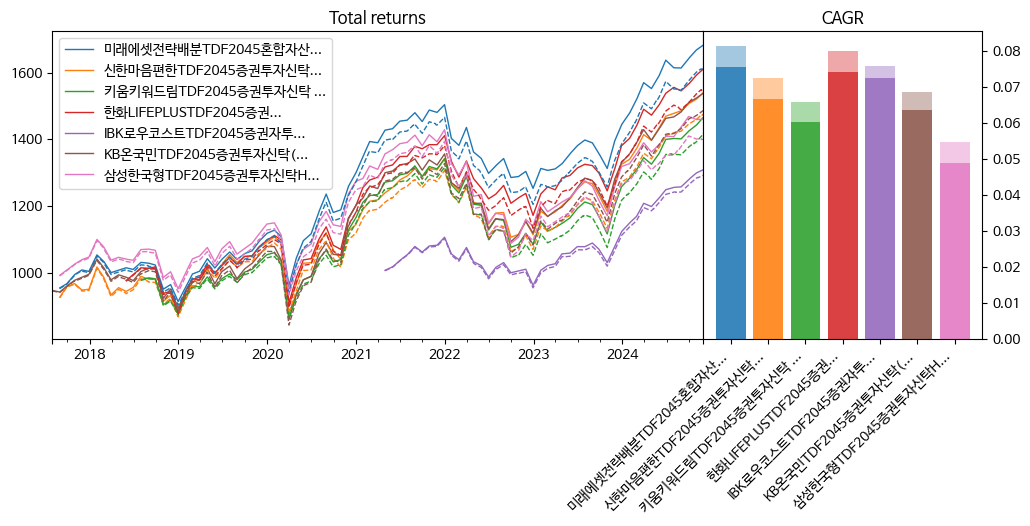

In [6]:
#m = 'total_return'
m = 'cagr'
fund.plot(tickers, fee=fee, base=-1, metric=m)

In [87]:
df = fund.df_prices[tickers]
df= df.loc[df.notna().any(axis=1)]

w = 365 * 2
df_ror = df.rolling(w).apply(lambda x: x.iloc[-1] / x.iloc[0] - 1).apply(lambda x: x.dropna())

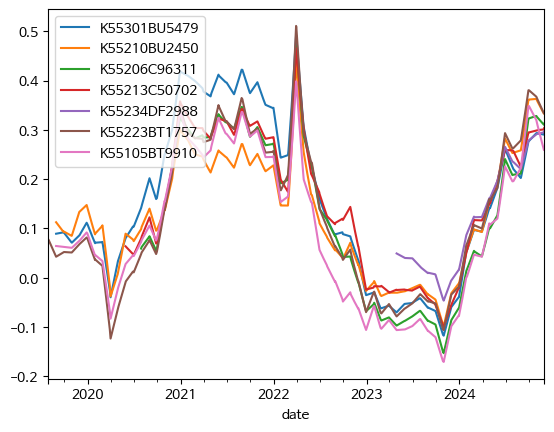

In [88]:
_ = df_ror.plot()

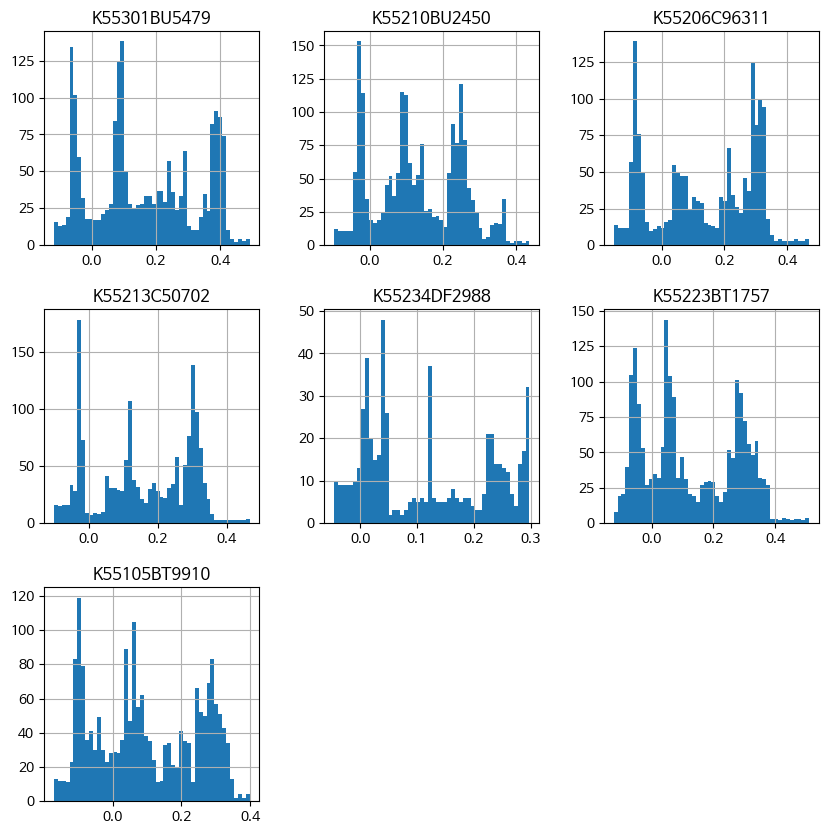

In [89]:
_ = df_ror.hist(bins=50, figsize=(10,10))

In [90]:
df_ror.apply(lambda x: x.loc[x > 0].dropna().count() / x.dropna().count())

K55301BU5479    0.781657
K55210BU2450    0.783220
K55206C96311    0.731230
K55213C50702    0.767922
K55234DF2988    0.886403
K55223BT1757    0.742051
K55105BT9910    0.693069
dtype: float64

In [65]:
df_ror.agg(['mean', 'std'])

,K55301BU5479,K55210BU2450,K55206C96311,K55213C50702,K55234DF2988,K55223BT1757,K55105BT9910
mean,0.080419,0.070898,0.076937,0.086856,0.059451,0.068864,0.053951
std,0.125761,0.113316,0.134982,0.120978,0.097699,0.133971,0.125645


In [12]:
from pf_utils import performance_stats, METRICS

In [13]:
performance_stats(df, metrics=METRICS)

,K55301BU5479,K55210BU2450,K55206C96311,K55213C50702,K55234DF2988,K55223BT1757,K55105BT9910
start,2021-04-30,2021-04-30,2021-04-30,2021-04-30,2021-04-30,2021-04-30,2021-04-30
end,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29
total_return,0.178707,0.242023,0.152964,0.222988,0.3,0.183772,0.077007
cagr,0.046946,0.062344,0.040515,0.057775,0.075954,0.048199,0.020916
calmar,0.281089,0.354791,0.204636,0.340782,0.581994,0.248329,0.087668
max_drawdown,-0.167016,-0.17572,-0.197987,-0.169537,-0.130506,-0.194095,-0.238581
avg_drawdown,-0.043088,-0.052399,-0.059419,-0.04835,-0.051307,-0.080494,-0.070569
avg_drawdown_days,201.2,225.25,249.5,227.5,272.0,309.666667,282.75
daily_vol,0.014031,0.015662,0.016776,0.013997,0.012462,0.016591,0.017853
daily_sharpe,2.263009,2.672159,1.641891,2.775797,4.059676,1.965997,0.808911


# testing

In [36]:
n = 6
tickers = df_year.loc[df_year >= n].index.to_list()
df_prices = df_prices[tickers]
len(tickers)

50

In [37]:
df_stats = performance_stats(df_prices, sort_by='cagr').T
tickers = df_stats.loc[df_stats['cagr'] > 0].index.to_list()
len(tickers)

49

In [41]:
n = 10
tickers = df_stats['cagr'].sort_values(ascending=False).iloc[:n].index.to_list()
tickers = df_stats['cagr'].sort_values(ascending=False).sample(n).index.to_list()
tickers = df_stats['cagr'].sort_values(ascending=False).head(round(n/2)).index.to_list()
tickers += df_stats['cagr'].sort_values(ascending=False).tail(round(n/2)).index.to_list()
df_prices = df_prices[tickers]

In [42]:
be = BayesianEstimator(df_prices, 365)

In [43]:
be.get_stats(sort_by='cagr')

,K55303BT4176,K55301BM7459,K55301BU5479,K55301BU6253,K55234BY9966,K55301BU5453,KR5101888398,KR5370AP9956,K55370BU1979,KR5223AE3357
start,2017-11-30,2017-03-31,2017-08-31,2017-08-31,2017-12-29,2017-10-31,2008-11-28,2014-04-30,2017-08-31,2017-08-31
end,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29
total_return,0.768898,0.806826,0.69376,0.685307,0.579819,0.262182,0.67542,0.237774,0.118573,0.012797
cagr,0.084917,0.080224,0.075421,0.074679,0.068333,0.033434,0.032774,0.020358,0.015582,0.001756
calmar,0.275892,0.464783,0.423466,0.434778,0.17224,0.283068,1.034065,0.098186,0.076702,0.005263
max_drawdown,-0.307791,-0.172605,-0.178104,-0.171763,-0.396728,-0.118112,-0.031694,-0.207339,-0.20315,-0.333674
avg_drawdown,-0.072877,-0.029751,-0.032562,-0.032562,-0.077548,-0.020966,-0.001507,-0.027249,-0.046284,-0.098934
avg_drawdown_days,251.222222,100.75,110.833333,109.5,218.8,134.214286,28.096774,147.363636,224.4,328.428571
daily_vol,0.024205,0.017082,0.017833,0.017284,0.032826,0.009205,0.002546,0.014424,0.015993,0.028531
daily_sharpe,2.335503,3.12562,2.822383,2.883856,1.40585,2.469764,8.740633,0.971232,0.67507,0.056703


In [44]:
be.bayesian_sample(freq='3y')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.


In [97]:
#var_names = ['ror', 'sharpe']
var_names = 'ror'
df = be.bayesian_summary(var_names)

In [98]:
func = lambda x: re.match(r"(.*)\[(.*)\]", x).groups()
df.index = [func(x)[1] for x in df.index]
tickers = df.loc[df['hdi_3%']>0].index

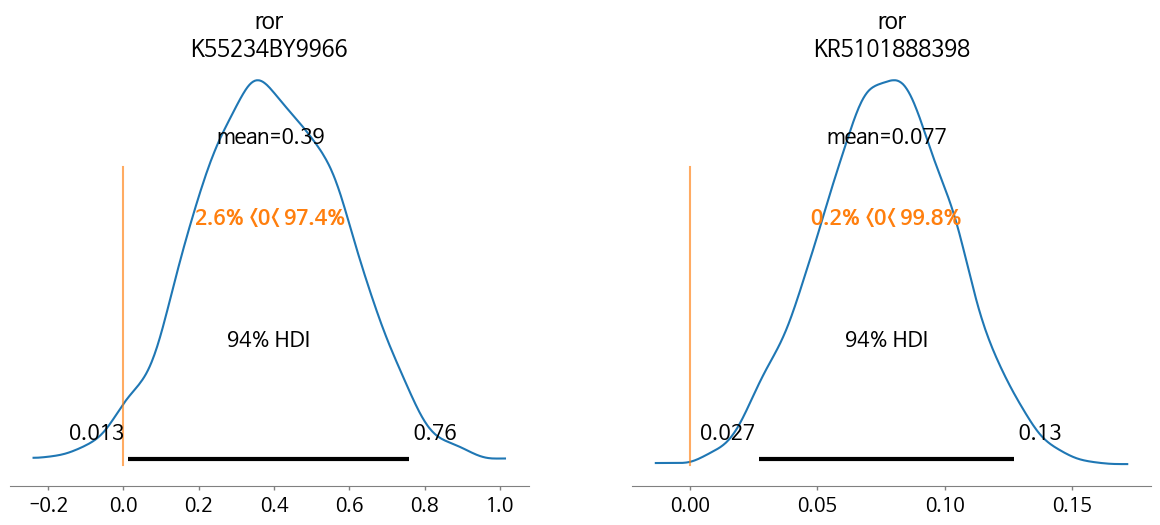

In [99]:
plot_posterior(be, var_names, tickers)

In [96]:
var_names[0]

'r'

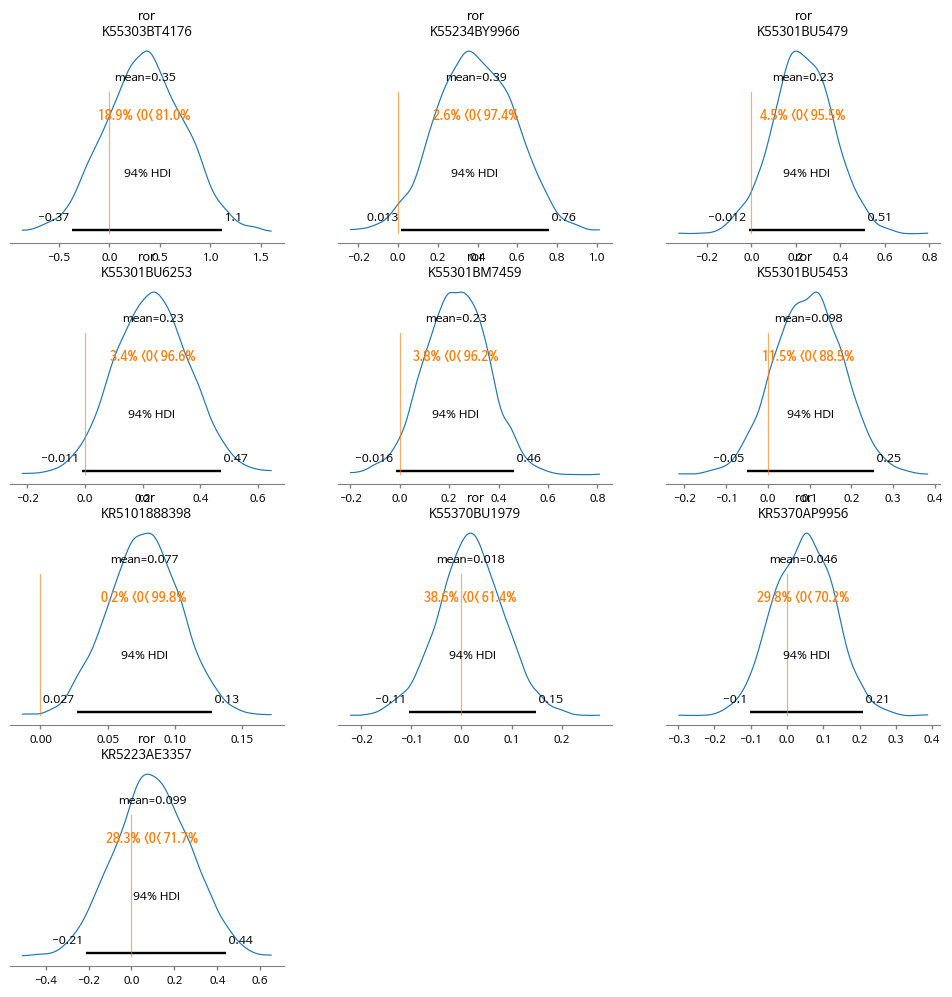

In [46]:
be.plot_posterior(var_names[0], figsize=(12,12), textsize=8)

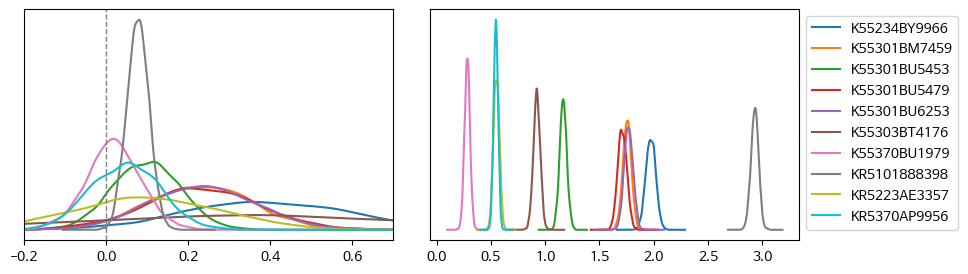

In [49]:
_ = be.plot_returns(xlim=(-0.2, 0.7))